## Проект: вариант 1

 Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:
 
1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

## Задание 1

 Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

   shared/problem1-auth_data.csv – данные о времени захода пользователей в игру

   shared/problem1-reg_data.csv – данные о времени регистрации
   
 Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [81]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';') 

In [83]:
def retention(reg, auth):
     
    # меняем тип данных
    reg['registration_date'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date
    auth['auth_data'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date
    
    # выбираем диапазон, на котором будет проверять работу функции
    reg = reg[(reg['registration_date'] >= datetime.date(2020, 5, 1))]
    auth = auth[(auth['auth_data'] <= datetime.date(2020, 5, 31))]

    # соединяем два датафрейма по uid
    all_data = pd.merge(auth, reg, on='uid')
    
    # считаем количество дней между регистрацией и заходом в игру
    all_data['days_after_reg'] = (all_data['auth_data'] - all_data['registration_date']).dt.days + 1

    # разбиваем на когорты и считаем retention игроков
    cohorts_ret = all_data.groupby(['registration_date', 'days_after_reg'])['uid'].nunique().reset_index() 
    cohorts = cohorts_ret.pivot(index='registration_date', columns='days_after_reg', values='uid') 
    base = cohorts[1] 
    retention = cohorts.divide(base, axis=0).round(3)
    
    plt.figure(figsize=(20, 10))
    plt.title('Retention_table')
    ax = sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.10, cmap='YlGnBu')
    ax.set_yticklabels(retention.index)
    plt.show()

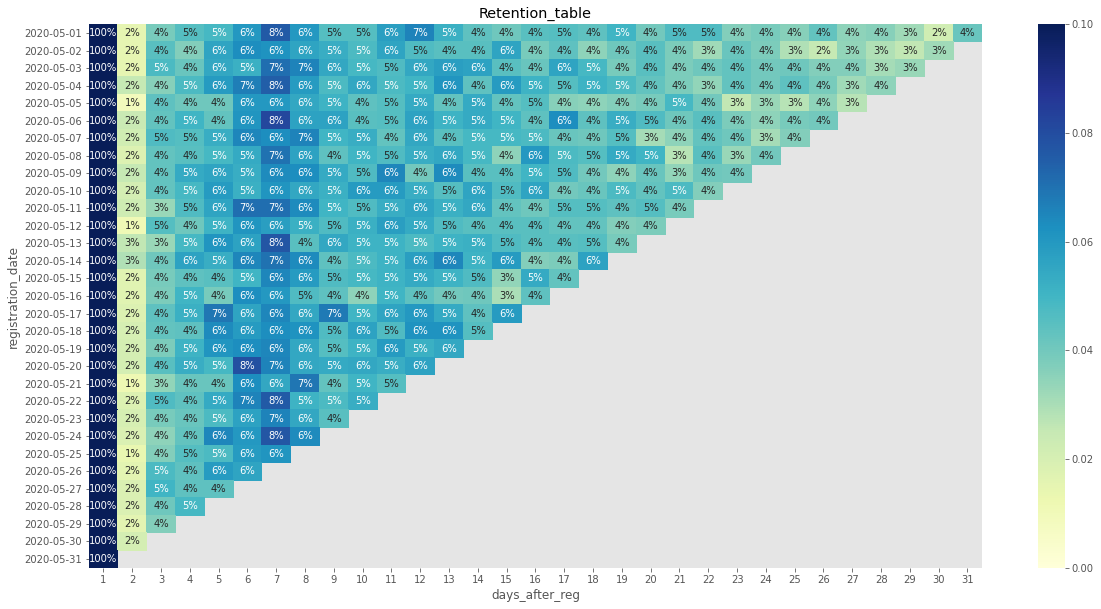

In [84]:
retention(reg_data, auth_data)

## Задание 2

 Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений.    Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

 Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [85]:
import pandas as pd
import numpy as np
from scipy import stats
plt.style.use('ggplot')

In [86]:
df = pd.read_csv('~/Проект_1_Задание_2.csv', sep=";")
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [87]:
# делим на группы датафрейм отдельно для посетителей и отдельно для покупателей
users_control = df.query('testgroup == "a"')
users_test = df.query('testgroup == "b"')
clients_control = users_control.query('revenue > 0')
clients_test = users_test.query('revenue > 0')

In [88]:
# расчитываем ARPU для обоих групп и проверяем разницу между ними
arpu_control = users_control.revenue.sum() / users_control.revenue.count()
arpu_test = users_test.revenue.sum() / users_test.revenue.count()
arpu_diff = (arpu_test - arpu_control) / arpu_test * 100
print(f'ARPU для контрольной группы: {arpu_control:.2f}')
print(f'ARPU для тестовой группы: {arpu_test:.2f}')
print(f'ARPU тестовой группы больше на: {arpu_diff:.2f}%')

ARPU для контрольной группы: 25.41
ARPU для тестовой группы: 26.75
ARPU тестовой группы больше на: 5.00%


In [89]:
# вычисляем ARPPU для обоих групп и проверяем разницу между ними
arppu_control = users_control.revenue.sum() / clients_control.revenue.count()
arppu_test = users_test.revenue.sum() / clients_test.revenue.count()
arppu_diff = (arppu_test - arppu_control) / arppu_test * 100
print(f'ARPPU для контрольной группы: {arppu_control:.2f}')
print(f'ARPPU для тестовой группы: {arppu_test:.2f}')
print(f'ARPPU тестовой группы больше на: {arppu_diff:.2f}%')

ARPPU для контрольной группы: 2664.00
ARPPU для тестовой группы: 3003.66
ARPPU тестовой группы больше на: 11.31%


In [90]:
# вычисляем конверсию
cr_control = 100 * clients_control.revenue.count() / users_control.revenue.count()
cr_test = 100 * clients_test.revenue.count() / users_test.revenue.count()
cr_diff = cr_control - cr_test
print(f'Конверсия для контрольной группы: {cr_control:.2f}')
print(f'Конверсия для тестовой группы: {cr_test:.2f}')
print(f'Конверсия контрольной группы больше на: {cr_diff:.2f}%')

Конверсия для контрольной группы: 0.95
Конверсия для тестовой группы: 0.89
Конверсия контрольной группы больше на: 0.06%


Из полученных подсчетов заметим                                                            
1. ARPU тестовой группы выше на 5%
2. ARPPU тестовой группы выше на 11%
3. А вот конверсия в контрольной группе выше примерно на 6%

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Тестовая группа')

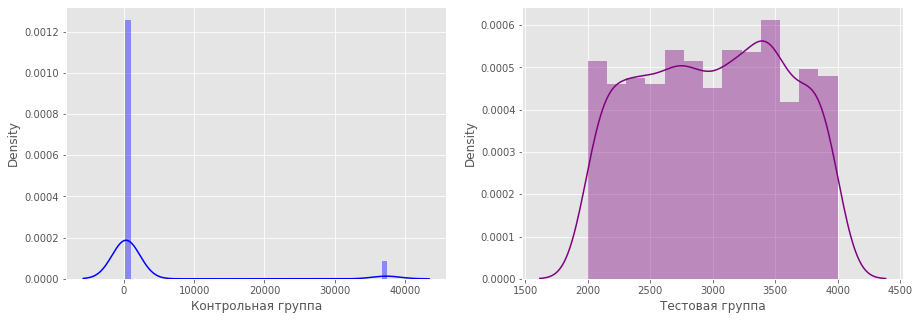

In [91]:
plt.rcParams['figure.figsize'] = (15, 5)

plt.subplot(1, 2, 1)
sns.distplot((users_control.query('revenue != 0').revenue), color='blue')
plt.xlabel('Контрольная группа')

plt.subplot(1, 2, 2)
sns.distplot((users_test.query('revenue != 0').revenue), color='purple')
plt.xlabel('Тестовая группа')

В контрольной группе распределение платежей неравномерно, имеется выброс в районе крупных покупок. В тестовой группе распределение наоборот равномерное, без выбросов.
 Применяем критерий Манна-Уитни, который к выбросам не чувствителен.

In [92]:
statistic, pvalue = stats.mannwhitneyu(clients_control.revenue, clients_test.revenue) 
print('statistic = ', statistic)
print('p-value = ', pvalue.round(3))

statistic =  222015.0
p-value =  0.0


По результатам U-теста Манна-Уитни P-value < 0.05, соответственно можем утверждать, что ARPU в тестовой группе статистически значимо выше, чем в контрольной.

Используем bootstrap для нахождения статистической значимости двух групп, относительно всех посетителей.
В качестве статистики выбираем медиану, ввиду наличия выбросов в контрольной группе.

In [93]:
def get_bootstrap(col1, col2, boot_it=1000, statistic=np.mean, bootstrap_conf_level=0.95):
    """
        col1: значения первой выборки
        col2: значения второй выборки
        boot_it: количество бутстрап-подвыборок
        statistic: интересующая статистика
        bootstrap_conf_level: уровень значимости
    """
    boot_len = max(len(col1), len(col2))
    boot_data = []
   
    for i in range(boot_it):
        samples_1 = col1.sample(boot_len, replace=True).values
        samples_2 = col2.sample(boot_len, replace=True).values
        boot_data.append(statistic(samples_1 - samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    p_1 = stats.norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = stats.norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    plt.hist(pd_boot_data[0], bins=50)
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    
    return {"boot_data": boot_data, "ci": ci, "p_value": p_value}

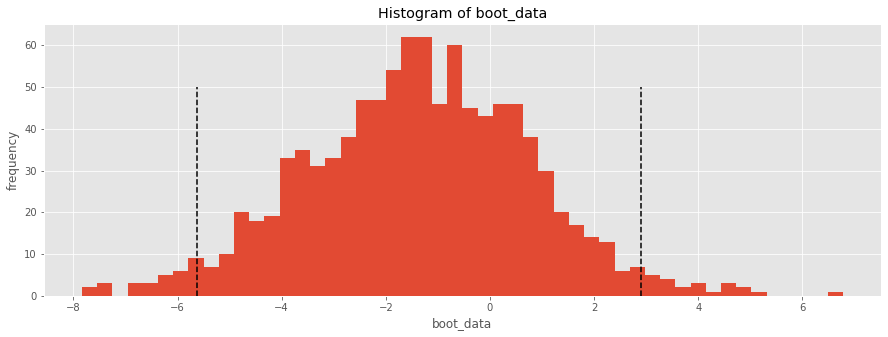

Результат bootstrap-теста:
p-value: 0.52


,0
0.025,-5.634525
0.975,2.904445


In [94]:
booted_data = get_bootstrap(users_control.revenue, users_test.revenue)
print('Результат bootstrap-теста:')
print(f'p-value: {booted_data["p_value"]:.2f}')
booted_data["ci"]

Из результата видно, что p-value > 0.05 и 0 попадает в доверительный интервал. Это означает, что
 значимых статистических различий нет

 Теперь сравним показатели только покупателей в тестовой и контррльной группе

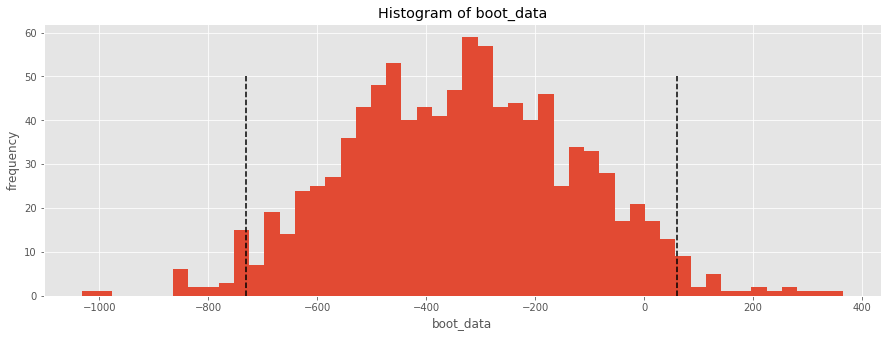

Результат bootstrap-теста:
p-value: 0.11


,0
0.025,-731.408519
0.975,60.522173


In [95]:
booted_data = get_bootstrap(clients_control.revenue, clients_test.revenue)
print('Результат bootstrap-теста:')
print(f'p-value: {booted_data["p_value"]:.2f}')
booted_data["ci"]

p_value также оказался больше 0.05, следовательно результат показывает отсутствие статистически значимых отличий покупателей в контрольной и тестовой группе

## Выводы:

Исходя из полученных данных нельзя однозначно сказать, какой набор предложений лучше, используя только имеющиеся данные. Видно, что такие метрики как ARPU и ARPPU в тестовой группе больше, а вот конверсия в тестовой группе оказалась меньше по сравнению с контрольной. Это может быть связанно с выбором недорогого набора акций, который и позволил увеличить конверсию. По результатам применения U-критерия Манна-Уитни показал значемые различия в группах, в тоже время по bootstrap, значимых различий на имеющихся данных выявлено не было. Считаю, что нужно более подробно проанализировать контрольную группу, выяснить какие отличительные особенности у нее есть (DAU, MAU, географические данные и т.д.), исходя из этого разработать специальный пакет акционных предложений. А вот как основной пакет акционных предложений можно взять из тестовой группы.

## Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?


### Метрики оценки результатов последнего прошедшего события

- DAU - количество уникальных пользователей за сутки в течение всего прошедшего события.
- MAU - количество уникальных пользователей, которые зашли в приложение в течение месяца.
- Retention - показатель изменения количества пользователей после проведения события.
- CR - отношение числа пользователей, которые выполнили какое-либо целевое действие к общему числу пользователей.
- LTV (lifetime value)  – пожизненная ценность клиента. Отражает сколько принесет пользователь денег в продукт до того, как покинет его.
- ARPDAU (повышение средних чеков у активных игроков в дни проведения событий).
- Средняя продолжительность сессии (average session length, ASL).
- Sticky Factor – интересное событие должно мотивировать новых пользователей остаться в игре.

### Метрики оценки после усложнения механики игры

К предыдущим метрикам добавить:
- Churn rate - как изменился отток клиентов.
- Уровень, на котором большинство участников переставали играть.
- Среднее количество пройденных уровней за одну игру.
- Среднее количество попыток прохождения каждого уровня.
- Среднее количество откатов.
- Среднее количество уровней до отката.
- Соотношение игроков, прошедших без откатов, к общему количеству прошедших.